In [2]:
%load_ext autoreload
%autoreload 2

from helpers import NormalizedEnv
from helpers import RandomAgent
import gym as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn

from copy import deepcopy
from tqdm import tqdm
import importlib
from helpers import NormalizedEnv

from heuristicpolicy import HeuristicPendulumAgent
from qnetwork import QNetwork
from replaybuffer import ReplayBuffer

In [3]:
#Creating pendulum object
pendulum = gym.make('Pendulum-v1', g=9.81)
#Wrapping pendulum to map output space to [-1,1]
pendulum = NormalizedEnv(pendulum)

#Create random agent
Random_Agent = RandomAgent(pendulum)

In [4]:
heuristic_agent = HeuristicPendulumAgent(pendulum)

In [5]:
#set GPU for faster training
cuda = torch.cuda.is_available() #check for CUDA
device   = torch.device("cuda" if cuda else "cpu")
print("Job will run on {}".format(device))

Job will run on cpu


In [6]:
MAX_IT = 200
BUFFER_SIZE = 1e4

BATCH_SIZE = 128
LEARNING_RATE = 1e-4
NUM_EPISODES = 1000
GAMMA = 0.99

In [47]:
torch.manual_seed(-1)

network  = QNetwork().to(device) # critic
memory = ReplayBuffer(max_size=BUFFER_SIZE)

In [48]:
#target_actor = HeuristicPendulumAgent(pendulum).to(device)

q_optimizer  = optim.Adam(network.parameters(),  lr=LEARNING_RATE)

MSE = nn.MSELoss()

In [9]:
agent = heuristic_agent

In [38]:
targets = []
q_state = []
loss = 0
for i in range(BATCH_SIZE):

    state, action, reward, next_state, trunc = batch_transitions[i]

    state = torch.FloatTensor(state).to(device)
    action = torch.FloatTensor([action]).to(device)
    reward = torch.FloatTensor([reward]).to(device) #.unsqueeze(1)
    trunc = torch.Tensor([np.float32(trunc)]).unsqueeze(1).to(device)
    next_state = torch.FloatTensor(next_state).to(device)

    action_next_state = agent.compute_action(state = next_state) # np

    # To compute the targets in each step, do not use the on-trajectory action, 
    # but compute a new action according to the policy
    network_input_state = torch.cat((state, action))

    network_input_next_state = torch.cat((next_state, torch.Tensor([action_next_state])))
    with torch.no_grad():
        # network_input_next_state or network_input_state
        q_next = network(network_input_next_state) # should not be differentiated 

    q_state.append([q_next]) # no grad??

    target_state = reward + GAMMA * q_next # the last update in each episode should use q = 0 ?
    targets.append(target_state)

    q = network(network_input_state)
    q_state.append(q)

    loss += MSE(target_state, q)

q_optimizer.zero_grad()
q_loss = loss/BATCH_SIZE
q_loss.backward()
q_optimizer.step()
q_loss.item()

12.417201042175293

In [49]:
def onestepTD(batch_transitions, agent, gamma, network):

    targets = []
    q_state = []
    loss = 0
    for i in range(BATCH_SIZE):

        state, action, reward, next_state, trunc = batch_transitions[i]

        state = torch.FloatTensor(state).to(device)
        action = torch.FloatTensor([action]).to(device)
        reward = torch.FloatTensor([reward]).to(device) #.unsqueeze(1)
        trunc = torch.Tensor([np.float32(trunc)]).unsqueeze(1).to(device)
        next_state = torch.FloatTensor(next_state).to(device)

        action_next_state = agent.compute_action(state = next_state) # np

        # To compute the targets in each step, do not use the on-trajectory action, 
        # but compute a new action according to the policy
        network_input_state = torch.cat((state, action))

        network_input_next_state = torch.cat((next_state, torch.Tensor([action_next_state])))
        with torch.no_grad():
            # network_input_next_state or network_input_state
            q_next = network(network_input_next_state) # should not be differentiated 

        q_state.append([q_next]) # no grad??

        target_state = reward + gamma * q_next # the last update in each episode should use q = 0 ?
        targets.append(target_state)

        q = network(network_input_state)
        q_state.append(q)

        loss += MSE(target_state, q)

    q_optimizer.zero_grad()
    q_loss = loss/BATCH_SIZE
    q_loss.backward()
    q_optimizer.step()
    
    return q_loss.item()

In [42]:
# sample a batch of transitions from the replay buffer
indices = np.random.randint(0, 200, 128)
batch_transitions = memory.sample_transition(indices)

In [43]:

i = 0
# collect experience
current_state = deepcopy(pendulum.reset()[0])
while i < MAX_IT:
    # how many iterations??
    action = heuristic_agent.compute_action(state = current_state)
    transformed_action = pendulum.action(action)
    next_state, reward, term, trunc, info = pendulum.step(transformed_action)

    memory.add_transition(state = current_state, action = action, reward = reward, next_state = next_state, trunc = trunc)
    i += 1

In [44]:
plot_reward = []
plot_policy = []
plot_q = []
plot_steps = []


best_reward = -np.inf
saved_reward = -np.inf
saved_ep = 0
average_reward = 0
global_step = 0
nr_of_samples = 128


In [45]:
losses = []
for episode in tqdm(range(NUM_EPISODES)):
    current_state = deepcopy(pendulum.reset()[0])

    ep_reward = 0.
    ep_q_value = 0.
    step=0

    i = 0
    # collect experience
    while i < MAX_IT:
        # how many iterations??
        action = heuristic_agent.compute_action(state = current_state)
        transformed_action = pendulum.action(action)
        next_state, reward, term, trunc, info = pendulum.step(transformed_action)

        memory.add_transition(state = current_state, action = action, reward = reward, next_state = next_state, trunc = trunc)

        current_state = deepcopy(next_state)
        ep_reward += reward
        i += 1

    # sample a batch of transitions from the replay buffer
    indices = np.random.randint(0, 200, nr_of_samples)
    batch_transitions = memory.sample_transition(indices)

    # 1-step TD-learning rule
    loss = onestepTD(batch_transitions, heuristic_agent, GAMMA, network)
    losses.append(loss)
    # plot_q.append([loss, episode])

    

100%|██████████| 1000/1000 [02:43<00:00,  6.11it/s]


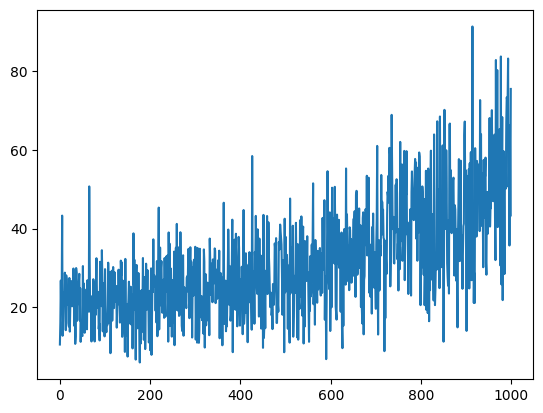

In [46]:
plt.plot(losses)

In [ ]:
from matplotlib import pyplot as plt
from IPython.display import clear_output
%matplotlib inline

def subplot(R, P, Q, S):
    r = list(zip(*R))
    p = list(zip(*P))
    q = list(zip(*Q))
    s = list(zip(*S))
    clear_output(wait=True)
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

    ax[0, 0].plot(list(r[1]), list(r[0]), 'r') #row=0, col=0
    ax[1, 0].plot(list(p[1]), list(p[0]), 'b') #row=1, col=0
    ax[0, 1].plot(list(q[1]), list(q[0]), 'g') #row=0, col=1
    ax[1, 1].plot(list(s[1]), list(s[0]), 'k') #row=1, col=1
    ax[0, 0].title.set_text('Reward')
    ax[1, 0].title.set_text('Policy loss')
    ax[0, 1].title.set_text('Q loss')
    ax[1, 1].title.set_text('Max steps')
    plt.show()

Text(0.5, 1.0, 'Q loss')

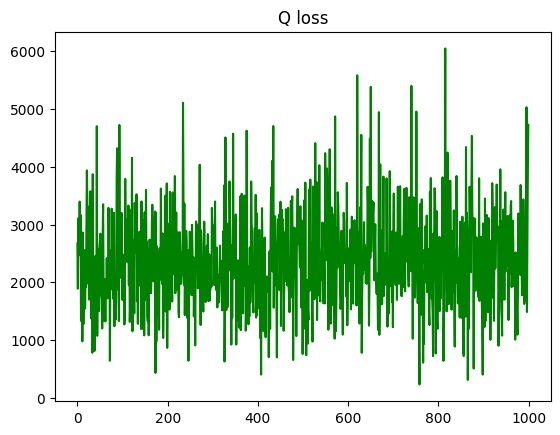

In [186]:
q = list(zip(*plot_q))
plt.plot(list(q[1]), list(q[0]), 'g') #row=0, col=1
plt.title('Q loss')

In [12]:
i = 0
while i < MAX_IT:
    action = heuristic_agent.compute_action(state = current_state)
    transformed_action = pendulum.action(action)
    next_state, reward, term, trunc, info = pendulum.step(transformed_action)

    memory.add_transition(state = current_state, action = action, reward = reward, next_state = next_state, trunc = trunc)

    current_state = deepcopy(next_state)
    ep_reward += reward
    i += 1

NameError: name 'current_state' is not defined

[(array([0.97788984, 0.20912069, 0.18009238], dtype=float32),
  -1.0,
  -0.051627571543737774,
  array([0.9775334 , 0.2107805 , 0.03395293], dtype=float32),
  False),
 (array([ 0.95440036,  0.2985296 , -2.3184805 ], dtype=float32),
  1.0,
  -0.6334360689743704,
  array([ 0.9773568 ,  0.21159807, -1.7988373 ], dtype=float32),
  False)]